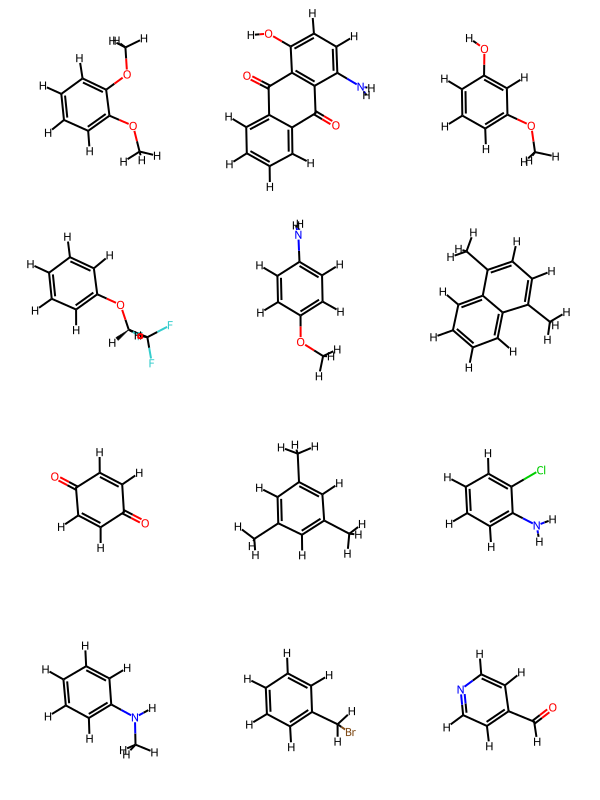

In [36]:
import numpy as np
from rdkit import Chem
from openfe_benchmarks import benzenes
from kartograf import KartografAtomMapper
from konnektor.visualization import draw_ligand_network
from openfe.setup.atom_mapping.lomap_scorers import default_lomap_score

system=benzenes.get_system()
compounds = system.ligand_components
compounds = list(filter(lambda x: not x.name in ["lig_2", "lig_3", "lig_4", "lig_7"], compounds))
Chem.Draw.MolsToGridImage ([c.to_rdkit() for c in compounds], )

# Radial Network Layout

In [3]:
from konnektor.network_planners import RadialLigandNetworkPlanner
ligand_network_planner = RadialLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [4]:
radial_network = ligand_network_planner(compounds)
radial_network.name="Radial"
radial_network

[LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_1), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={8: 16, 10: 10, 12: 9, 13: 12, 14: 13, 15: 14, 16: 15, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}, annotations={'score': 0.22119921692859512}), LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_6), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={7: 15, 9: 10, 11: 8, 12: 12, 13: 13, 14: 14, 16: 16, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7}, annotations={'score': 0.1392920235749422}), LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_8), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={1: 10, 13: 9, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 3: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7}, annotations={'score': 0.36237184837822667}), LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_9), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB=

/home/bries/programs/miniconda3/envs/openfe/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/tmp/ipykernel_17989/360503311.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


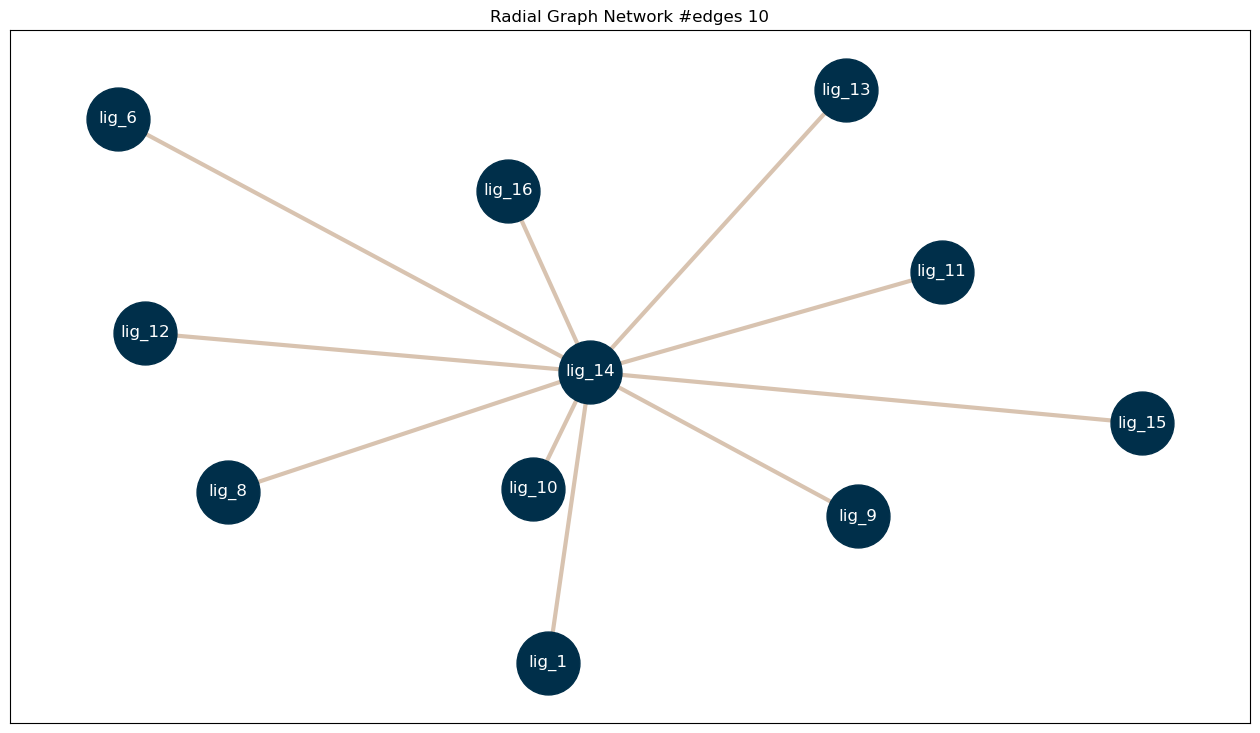

In [5]:
fig = draw_ligand_network(radial_network, title="Radial Graph");
fig.savefig(radial_network.name+"_Network.png")
fig.show()

# Minimal Spanning Tree

In [6]:
from konnektor.network_planners import MinimalSpanningTreeLigandNetworkPlanner

ligand_network_planner = MinimalSpanningTreeLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [7]:
mst_network = ligand_network_planner(compounds)
mst_network.name="MST"
mst_network

/tmp/ipykernel_17989/2295833610.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


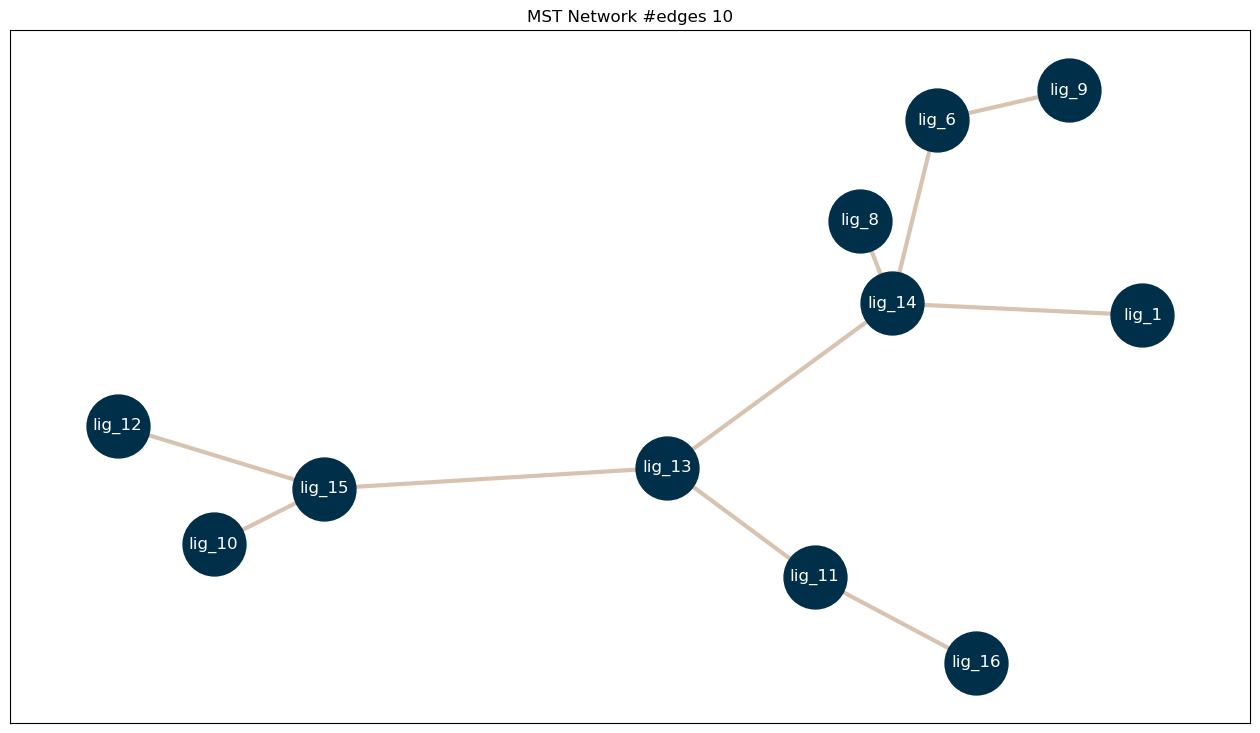

In [8]:
fig = draw_ligand_network(mst_network, "MST");
fig.savefig("MST_Network.png")
fig.show()

# Cyclo Graphs

In [9]:
from konnektor.network_planners import CyclicLigandNetworkPlanner
ligand_network_planner = CyclicLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score,
                                                    cycle_sizes=3, node_present_in_cycles=1)

In [10]:
cyclic_network = ligand_network_planner(compounds)
cyclic_network.name="Cyclic"
cyclic_network

ERROR:	
Timings:
--------
ERROR:		 Cycle generation duration: 0:00:00.012360
ERROR:		 Cycle selection duration: 0:00:00.000331
ERROR:		 total duration: 0:00:00.013021


/tmp/ipykernel_17989/1302321791.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


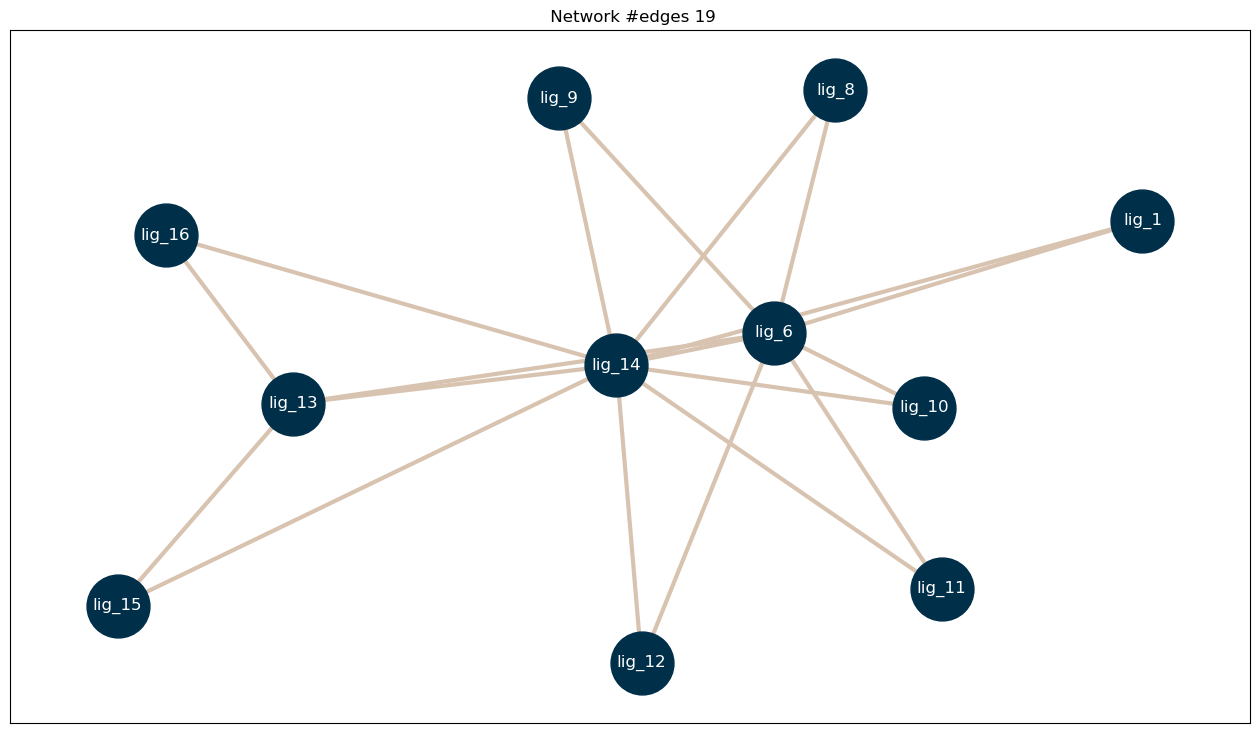

In [11]:
fig = draw_ligand_network(cyclic_network);
fig.savefig(cyclic_network.name+"_Network.png")
fig.show()

In [ ]:
import networkx as nx
from matplotlib import pyplot as plt

ng=ligand_network_planner.network_generator
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[16,9])
nx.draw_networkx(ng.orig_g, with_labels=True, ax=axes[0])
nx.draw_networkx(ng.cyclic_graph, with_labels=True, ax=axes[1])


axes[0].set_title("fully connected graph"+" #edges "+str(len(ng.orig_g.edges)))
axes[1].set_title("node in cycles "+str(ng.node_cycle_connectivity)+", cycle_size "+str(ng.sub_cycle_size_range)+" #edges "+str(len(ng.cyclic_graph.edges)))
fig.suptitle("Algorithm I")

Text(0.5, 0.98, 'Algorithm I')

# Maximally connected network

In [20]:
from konnektor.network_planners import MaximalNetworkPlanner
ligand_network_planner = MaximalNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [21]:
max_network = ligand_network_planner(compounds)
max_network.name = "Max"
max_network

/tmp/ipykernel_17989/323473944.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


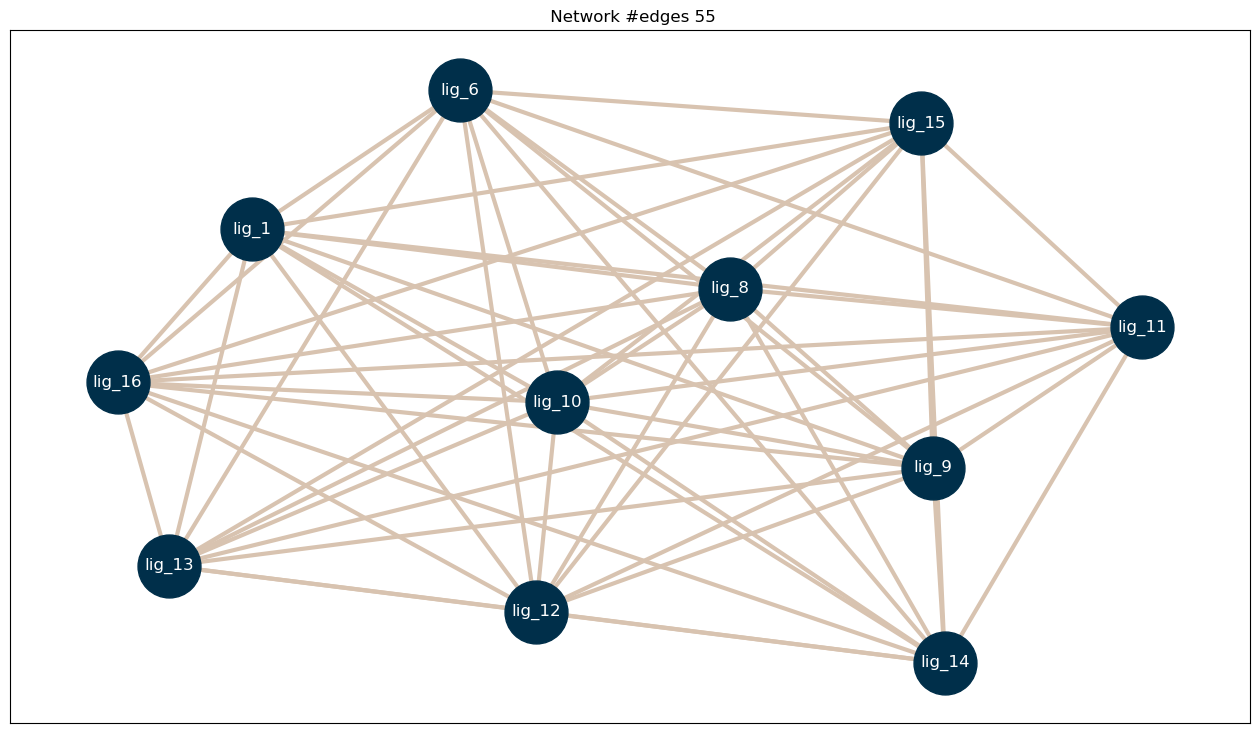

In [22]:
fig = draw_ligand_network(max_network);
fig.savefig(max_network.name+"_Network.png")
fig.show()

# Summary

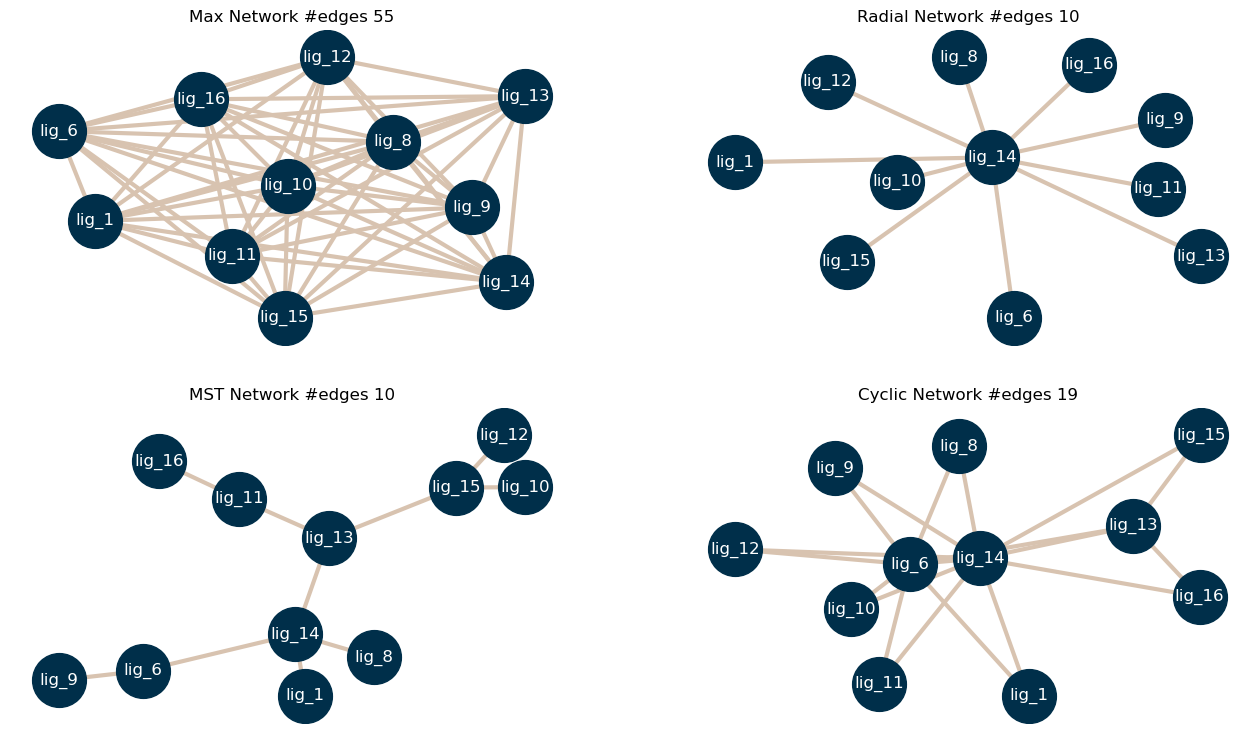

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16,9])
axes= np.array(axes).flat
for ax, net in zip(axes, [max_network, radial_network, mst_network, cyclic_network]):
    draw_ligand_network(network=net, title=net.name, ax=ax, node_size=1500)
    ax.axis("off")


In [30]:
fig.savefig("../.img/network_layouts.png", dpi=400)

## in one cell:

[LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_1), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={8: 16, 10: 10, 12: 9, 13: 12, 14: 13, 15: 14, 16: 15, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}, annotations={'score': 0.22119921692859512}), LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_5), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={5: 14, 20: 16, 21: 15, 0: 1, 1: 2, 2: 7, 3: 6, 4: 5, 6: 4, 7: 3}, annotations={'score': 0.8347011117784136}), LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_6), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={7: 15, 9: 10, 11: 8, 12: 12, 13: 13, 14: 14, 16: 16, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7}, annotations={'score': 0.1392920235749422}), LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_8), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={1: 10, 13: 9, 14: 12, 15: 13, 16: 14, 1

ERROR:	
Timings:
--------
ERROR:		 Cycle generation duration: 0:00:00.014907
ERROR:		 Cycle selection duration: 0:00:00.000395
ERROR:		 total duration: 0:00:00.015554


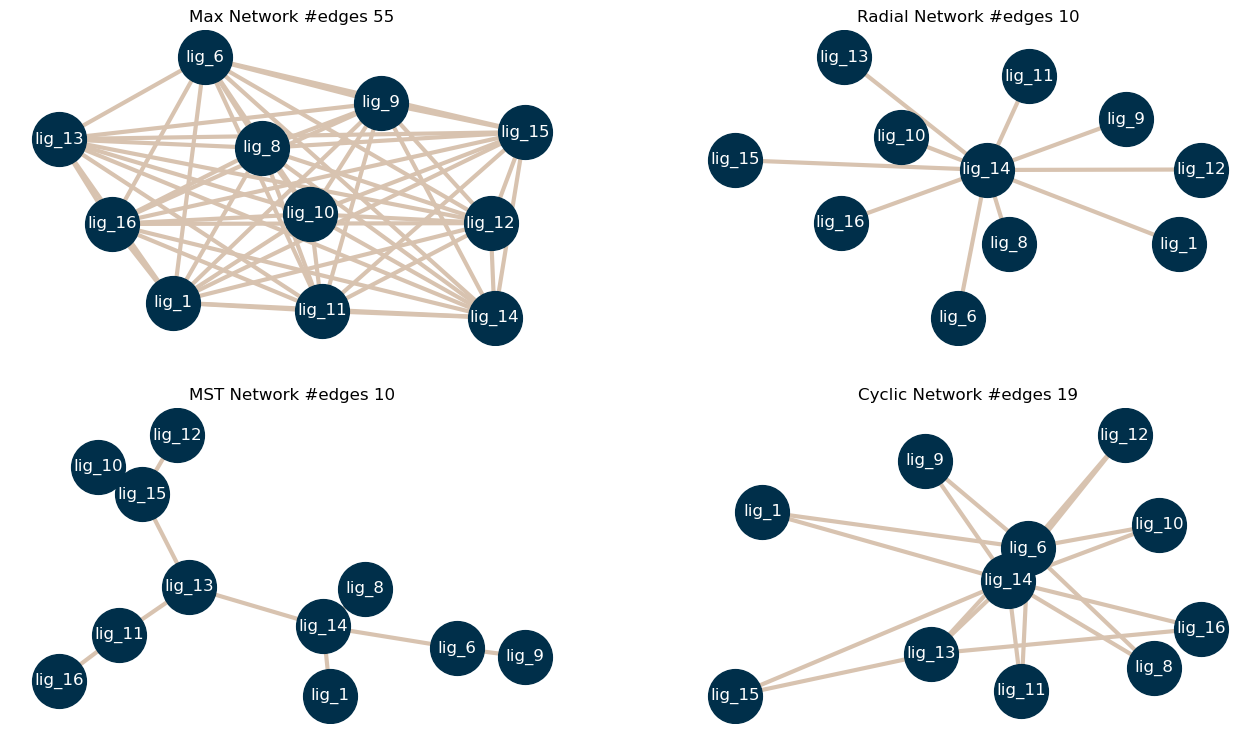

In [37]:
import numpy as np
from openfe_benchmarks import benzenes
from kartograf import KartografAtomMapper
from konnektor.visualization import draw_ligand_network
from openfe.setup.atom_mapping.lomap_scorers import default_lomap_score

compounds = list(filter(lambda x: not x.name in ["lig_2", "lig_3", "lig_4", "lig_7"],
                        benzenes.get_system().ligand_components))

from konnektor.network_planners import (MaximalNetworkPlanner, RadialLigandNetworkPlanner,
                                        MinimalSpanningTreeLigandNetworkPlanner, CyclicLigandNetworkPlanner)

networkers = [MaximalNetworkPlanner, RadialLigandNetworkPlanner,
              MinimalSpanningTreeLigandNetworkPlanner, CyclicLigandNetworkPlanner]

networks = []
for networker_cls, name in zip(networkers,["Max", "Radial", "MST", "Cyclic"]):
    networker = networker_cls(mapper=KartografAtomMapper(), scorer=default_lomap_score)
    network = networker(compounds)
    network.name=name
    networks.append(network)

#Visualize
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16,9])
axes= np.array(axes).flat
for ax, net in zip(axes, [max_network, radial_network, mst_network, cyclic_network]):
    draw_ligand_network(network=net, title=net.name, ax=ax, node_size=1500)
    ax.axis("off")

fig.show()
